In [2]:
import tensorflow as tf
print(tf.__version__)


2.19.0


In [9]:
import os

dataset_path = "dataset"

for categoria in ["piezas_buenas", "piezas_malas"]:
    ruta = os.path.join(dataset_path, categoria)
    archivos = os.listdir(ruta)
    print(f"{categoria}: {len(archivos)} imágenes")


piezas_buenas: 245 imágenes
piezas_malas: 90 imágenes


In [3]:
import os
import cv2
import numpy as np

# Ruta a la carpeta dataset
DATASET_PATH = "dataset"
IMG_SIZE = 128

# Etiquetas: piezas buenas = 0, piezas malas = 1
CATEGORIES = ["piezas_buenas", "piezas_malas"]

data = []

# Recorremos ambas categorías
for label, category in enumerate(CATEGORIES):
    folder_path = os.path.join(DATASET_PATH, category)
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        try:
            # Leer la imagen en escala de grises(hemos cambiado a color porque tenemos fallas por quemaduras)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
             # 🎨 Convertir de BGR a RGB (OpenCV usa BGR por defecto)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # Redimensionar a 128x128
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            # Normalizar valores (de 0-255 a 0-1)
            img = img / 255.0
            # Añadir a la lista de datos junto con su etiqueta (0 o 1)
            data.append([img, label])
        except Exception as e:
            print(f"⚠️ Error al procesar {img_path}: {e}")

# Mezclar los datos aleatoriamente
import random
random.shuffle(data)

# Separar datos y etiquetas
X = []
y = []

for features, label in data:
    X.append(features)
    y.append(label)

# Convertir a arrays de numpy
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)

print("✅ Imágenes preprocesadas correctamente")
print("🔢 Tamaño de X:", X.shape)
print("🔢 Tamaño de y:", y.shape)


✅ Imágenes preprocesadas correctamente
🔢 Tamaño de X: (335, 128, 128, 3)
🔢 Tamaño de y: (335,)


In [7]:
!pip install scikit-learn


You should consider upgrading via the 'C:\Users\bryan\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


✅ Datos divididos:
📊 X_train: (268, 128, 128, 3)
📊 X_val: (67, 128, 128, 3)
Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 794ms/step - accuracy: 0.7606 - loss: 0.6927 - val_accuracy: 0.3134 - val_loss: 0.6944
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 767ms/step - accuracy: 0.7232 - loss: 0.6909 - val_accuracy: 0.3134 - val_loss: 0.6938
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 773ms/step - accuracy: 0.7999 - loss: 0.6880 - val_accuracy: 0.4925 - val_loss: 0.6933
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 765ms/step - accuracy: 0.7498 - loss: 0.6869 - val_accuracy: 0.4776 - val_loss: 0.6933
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 775ms/step - accuracy: 0.7485 - loss: 0.6851 - val_accuracy: 0.4179 - val_loss: 0.6937
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 777ms/step - accuracy: 0.7417 - loss: 0.6836 - val_accuracy: 0.3284 - val_loss: 0.6945
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 823ms/step - accuracy: 0.7442 - loss: 0.6818 - val_accuracy: 0.3134 - val_loss: 0.6961
Epoch 8/30
17/17 ━━━━

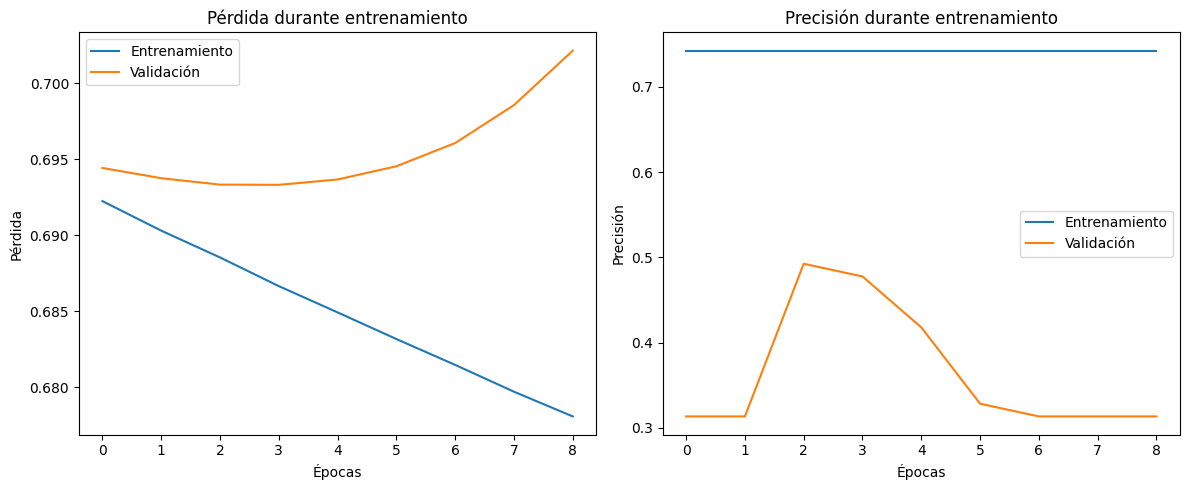

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1️⃣ Dividir los datos
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("✅ Datos divididos:")
print("📊 X_train:", X_train.shape)
print("📊 X_val:", X_val.shape)

# 2️⃣ Crear el modelo CNN
model = Sequential([
    Conv2D(256, (3, 3), activation='relu', padding='same', input_shape=(X.shape[1], X.shape[2], 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.5),  # Más regularización
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')  # Clasificación binaria
])

# 3️⃣ Compilar modelo
model.compile(optimizer=Adam(learning_rate=0.0005),  # Aprendizaje más fino
              loss='binary_crossentropy',
              metrics=['accuracy'])


# 🛑 Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# 🧠 Entrenar el modelo
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    epochs=30,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)

# 5️⃣ Gráficas de desempeño
plt.figure(figsize=(12, 5))

# 🔻 Pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title("Pérdida durante entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.legend()

# ✅ Precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title("Precisión durante entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.legend()

plt.tight_layout()
plt.show()


In [40]:
model.save("mi_modelo.keras")
